# Show flaws in the expression for trend uncertainty from Leroy (2008)

Leroy has a single term for trend uncertainty $\delta m$ that is derived from the uncertainty of a linear regression slope. But there should also be a component of trend "uncertainty" from slow climate variations that shift the measured slope $m_{est}$ without adding scatter. Here, I want to mathematically show that $\delta m$ is small for low frequency noise, helping to guide our intuition motivating a second term for trend uncertainty that arises from a shift in the slope.

Mean-square estimate of the uncertainty in a regressed slope $\langle (\delta m)^2 \rangle$ (Eq. 3):

$$ \langle (\delta m)^2 \rangle = \left[ \sum_{k=1}^N (t_k - \bar{t})^2 \right]^{-2} \sum_{i=1}^N\sum_{j=1}^N (t_i - \bar{t})(t_j - \bar{t}) \langle\delta d_i \delta d_j \rangle $$

The point-wise correlation term $\langle\delta d_i \delta d_j \rangle$ is assumed to be a function of the time between points (lag):

$$ \langle\delta d_i \delta d_j \rangle = \sigma_{var}^2 \textrm{Corr}_{i-j}(\textrm{var}), $$

where $\textrm{Corr}_{n}(\textrm{var})$ is the correlation function of natural variability at lag $n dt$ in time and $\sigma_{var}^2$ is the zero-lag variance associated with natural variability. Ignoring uncertainty from observing instruments and making assumptions from Leroy (2008) about the first and last elements of the time series, the uncertainty in the estimate of the trend becomes:  

$$ \langle (\delta m)^2 \rangle = \left[ \sum_{k=1}^N (t_k - \bar{t})^2 \right]^{-1} \left[ \sigma_{var}^2 \sum_{\mu=-\infty}^{\infty} \textrm{Corr}_{\mu}(\textrm{var}) \right] $$

The summations are exactly the normalized Fourier transforms of the natural variability and of the measurement uncertainty time-lagged covariance functions at zero frequency, and so they can be rewritten in terms of correlation times for the natural variability $\tau_{var}$ and for the measurement uncertainty $\tau_{meas}$:

$$ \tau_{var} \equiv dt \sum_{\mu=-\infty}^{\infty} \textrm{Corr}_{\mu}(\textrm{var}) $$

Confusing wording: ""The summations are exactly the normalized Fourier transforms of the natural variability and of the measurement uncertainty time-lagged covariance functions at zero frequency, and so they can be rewritten in terms of correlation times for the natural variability $\tau_{var}$ and for the measurement uncertainty $\tau_{meas}$."

__Another thing: There is power at low frequencies, but it is noise (i.e. not statistically significant). This means that the autocorrelation for long lags is effectively zero. This tells us something different from the power spectra. Effectively, points that are far apart in a timeseries are uncorrelated and won't increase the correlation time $\tau_{var}$, but they can still be affected by the same internal variability.__

Trying to resolve my confusion above^. From the Weiner-Khinchin Theorem, we have:

$$ \textrm{Corr}_{\mu}(\textrm{var}) = \mathcal{F}_{\nu}[|E_{\nu}|^2](t), $$

where $E_{\nu}$ is the power series (Fourier Transform) of a timeseries of unforced variability $E(t)$, and $\mathcal{F}_{\nu}$ is an inverse Fourier transform from frequency to time space. This relationship can be quickly derived using the definition of the autocorrelation and the convolution theorem (convolving in time space is multiplying in frequency space).

https://mathworld.wolfram.com/Wiener-KhinchinTheorem.html

Plugging the last equation into our expression for $\tau_{var}$, we get

$$ \tau_{var} \equiv dt \sum_{\mu=-\infty}^{\infty} \mathcal{F}_{\nu}[|E_{\nu}|^2](t) $$

From this expression, I should be able to easily test if high frequency noise has a different correlation time from low frequency noise. The low frequency noise should have a longer correlation time, which isn't wrong and maybe disproves our point...

### Do imports

In [2]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the CESM1-LE PI-Control Simulations

#### Collect paths for the PI-control run for each variable

In [3]:
cesm1le_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

pi_path_dict = {}
ens_vars = ['FLUT','TS']

for _var in ens_vars:
    _pi_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesm1le_path,_var))    
    
    pi_path_dict[_var] = _pi_files

#### Calculate an Arctic timeseries for the CESM1-LE PI-Control simulations (for each variable of interest)

In [274]:
%%time

cesm_vars = ['TS','FLUT']
pic_var_dict_cesm1 = {}

for _var in cesm_vars:
    print(_var)
    # Open all the PI-Control data
    pi_bigds = xr.open_mfdataset(pi_path_dict[_var],parallel=True) 
    # Fix the time coordinate, subset the Arctic, and add weights
    pi_subset = fix_cesm_time(pi_bigds)[_var].sel(lat=slice(70,None)).chunk({'lat':-1,'lon':-1}) # lowest lat. is 70.2
    pi_bigds.close()
    pi_subset_wgtd = add_weights(pi_subset)
    pi_subset.close()
    
    # Perform an area-weighted average and rechunk to put into a timeseries.
    pi_tseries = pi_subset_wgtd.weighted(pi_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])
    pi_subset_wgtd.close()
    pi_tseries_clean = pi_tseries.chunk({'time':-1})
    pi_tseries.close()
    
    # Add a name so that we can merge variables into a single ds
    pi_tseries_clean.name = _var
    
    pic_var_dict_cesm1[_var] = pi_tseries_clean.compute() # compute and save appropriately, takes surprisingly long
    pi_tseries_clean.close()
    
cesm1_pic_ds = xr.merge(pic_var_dict_cesm1.values())

del pic_var_dict_cesm1 # this might be surprisingly slow.
# del pi_bigds
# del pi_subset
# del pi_subset_wgtd
# del pi_tseries
# del pi_tseries_clean

TS
FLUT
CPU times: user 34.4 s, sys: 4.53 s, total: 38.9 s
Wall time: 53.9 s


In [275]:
def standardize(data):
    ''' Standardize the data. '''
    
    data_std = (data - data.mean()) / data.std()
    
    np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
    np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    
    return data_std

In [9]:
cesm1_ts = cesm1_pic_ds['TS']
cesm1_annualavg = cesm1_ts.groupby('time.year').mean()
cesm1_annualavg_std = standardize(cesm1_annualavg)

In [277]:
cesm1_olr = cesm1_pic_ds['FLUT']
cesm1_olr_annualavg = cesm1_olr.groupby('time.year').mean()
cesm1_olr_annualavg_std = standardize(cesm1_olr_annualavg)

### Step back and predict the "emergence time" using the Leroy/Weatherhead method

From Weatherhead et al. (1998):  

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

where $n^*$ is the number of years needed to dect a real trend of magnitude $|\omega_0|$ with probability $0.90$, $\phi$ is the lag-1 autocorrelation, $\sigma_{\epsilon}$ is the standard deviation of random noise, and $\sigma_{N}$ is the standard deviation of the variable after a linear trend is removed.

From Leroy et al. (2008), after ignoring measurement error:  

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{var} \right]^{1/3}, $$

where $\Delta t$ is the number of years needed to detect a real trend of magnitude $m_{est}$, $\tau_{var}$ is the correlation time for natural variability, and $\sigma_{var}$ is the standard deviation of natural variability. The meaning of $\tau_{var}$ is confusing, but it can be thought of as the number of timesteps until the correlation function reaches zero/the natural noise. This is complicated by correlation functions with different shapes and definitions of noise.

For the 95% confidence interval, the signal-to-noise ratio $s$ is taken to be $s=2$.

If these definitions are equivalent, then we should have 

$$ 12 s^2 \tau_{var} = \left(3.3^2 \frac{1+\phi}{1-\phi} \right) $$

In [225]:
# Work with the annual average data to start
cesm1_annualavg_stddev = cesm1_annualavg.std()
cesm1_ts_annavg_autocorr = np.correlate(cesm1_annualavg_std,cesm1_annualavg_std,mode='same') / len(cesm1_annualavg_std)

lag1_index = len(cesm1_ts_annavg_autocorr) // 2 + 1
lag1_autocorr_cesm1_ts = cesm1_ts_annavg_autocorr[lag1_index]

In [279]:
# Work with the annual average data to start
cesm1_olr_annualavg_stddev = cesm1_olr_annualavg.std()
cesm1_olr_annavg_autocorr = np.correlate(cesm1_olr_annualavg_std,cesm1_olr_annualavg_std,mode='same') / len(cesm1_olr_annualavg_std)

lag1_index_olr = len(cesm1_olr_annavg_autocorr) // 2 + 1
lag1_autocorr_cesm1_olr = cesm1_olr_annavg_autocorr[lag1_index_olr]

In [292]:
print('Annual mean TS standard deviation: %.2f K' % cesm1_annualavg_stddev)
print('Annual mean OLR standard deviation: %.2f Wm^-2' % cesm1_olr_annualavg_stddev)

Annual mean TS standard deviation: 0.64 K
Annual mean OLR standard deviation: 1.15 Wm^-2


In [293]:
print('Annual mean TS lag-1 autocorrelation: %.2f K' % lag1_autocorr_cesm1_ts)
print('Annual mean OLR lag-1 autocorrelation: %.2f Wm^-2' % lag1_autocorr_cesm1_olr)

Annual mean TS lag-1 autocorrelation: 0.44 K
Annual mean OLR lag-1 autocorrelation: 0.21 Wm^-2


The standard deviation of OLR is significantly less than that of surface temperature, which should slow detection.

The auto-correlation of OLR is significantly less than that of surface temperature, which should speed detection.

How will these factors balance?

In [280]:
lag1_autocorr_cesm1_olr

0.21470387510963615

In [281]:
lag1_autocorr_cesm1_ts

0.44137334518258403

In [213]:
3.3**2 * (1+lag1_autocorr_cesm1_ts) / (1-lag1_autocorr_cesm1_ts)

28.098472555285916

In [185]:
autocorr_lags = np.arange(-1*(len(cesm1_ts_annavg_autocorr) // 2),len(cesm1_ts_annavg_autocorr) // 2+1)

(-30.0, 30.0)

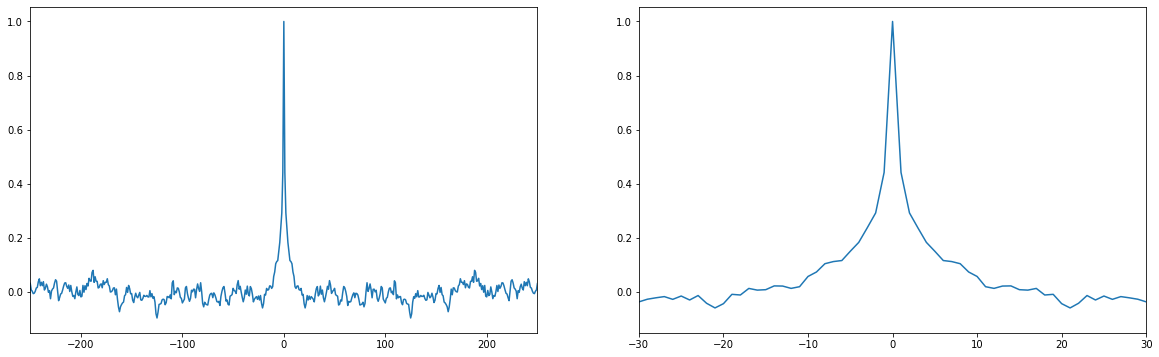

In [241]:
auto_fig,auto_axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
auto_axs[0].plot(autocorr_lags,cesm1_ts_annavg_autocorr)
auto_axs[0].set_xlim(-250,250)

auto_axs[1].plot(autocorr_lags,cesm1_ts_annavg_autocorr)
auto_axs[1].set_xlim(-30,30)

(-30.0, 30.0)

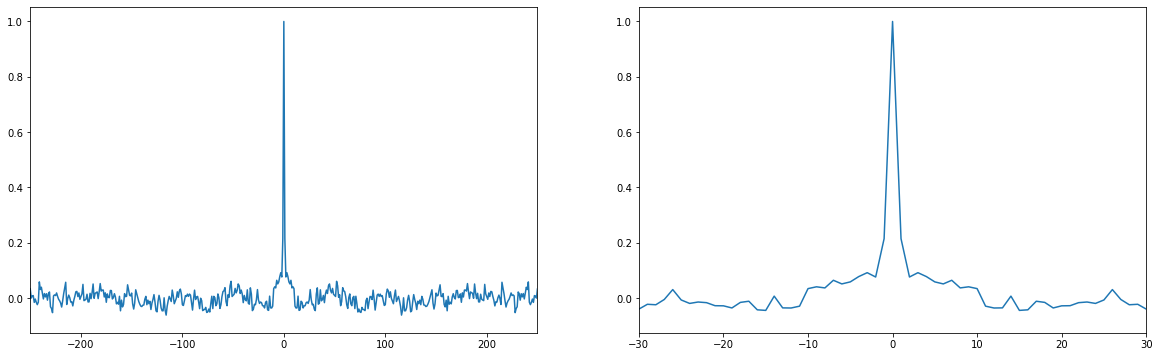

In [300]:
auto_fig,auto_axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
auto_axs[0].plot(autocorr_lags,cesm1_olr_annavg_autocorr)
auto_axs[0].set_xlim(-250,250)

auto_axs[1].plot(autocorr_lags,cesm1_olr_annavg_autocorr)
auto_axs[1].set_xlim(-30,30)

The autocorrelation function for OLR is much sharper than for TS, implying less autocorrelation. Both autocorrelation functions have a noticeable pedestal, but the TS pedestal is clearly larger. I expect the $\tau$ values to be larger for TS.

In [303]:
autocorr_noise_ts = np.std(cesm1_ts_annavg_autocorr[:800]) # assume the first 800 correlations don't matter and calculate the standard deviation from them

# calculate the correlation time by "removing" the noise
cesm1_ts_annavg_autocorr[np.abs(cesm1_ts_annavg_autocorr) > (2*autocorr_noise_ts)].sum() # use the absolute magnitude because otherwise you bias positive

2.5469584413358186

In [307]:
autocorr_noise_olr = np.std(cesm1_olr_annavg_autocorr[:800]) # assume the first 800 correlations don't matter and calculate the standard deviation from them

# calculate the correlation time by "removing" the noise
cesm1_olr_annavg_autocorr[np.abs(cesm1_olr_annavg_autocorr) > (2*autocorr_noise_olr)].sum() # use the absolute magnitude because otherwise you bias positive

1.4857855217721634

In [313]:
# cesm1_ts_annavg_autocorr[880:920] # look at the nearby autocorrelation values

# calculate the correlation time by adding up the correlation coefficients when there is a monotonic increase and they exceed the noise
arb_pts_ts = np.array([
        0.05650763,  0.07308405,  0.10372164,  
        0.1116101 ,  0.11545564,  0.14976355,  0.18261169,  0.23623026,  
        0.29159245,  0.44137335,  1.        ,  0.44137335,  0.29159245,  
        0.23623026,  0.18261169,  0.14976355,  0.11545564,  0.1116101 ,  
        0.10372164,  0.07308405,  0.05650763,]
)

np.sum(arb_pts_ts)

4.52390072

In [316]:
# cesm1_olr_annavg_autocorr[881:920] # look at the nearby autocorrelation values

arb_pts_olr = np.array([
        0.03665315,  0.06425754,  0.05111394,  0.0584116 ,
        0.07762514,  0.09172522,  0.07611249,  0.21470388,  1.        ,
        0.21470388,  0.07611249,  0.09172522,  0.07762514,  0.0584116 ,
        0.05111394,  0.06425754,  0.03665315,]
)

np.sum(arb_pts_olr)

2.34120592

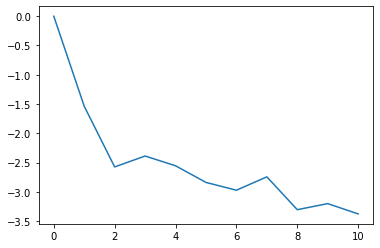

In [323]:
plt.plot(autocorr_lags[900:914],np.log(cesm1_olr_annavg_autocorr[900:914]))

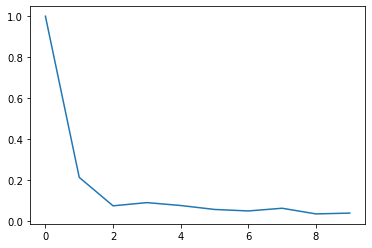

In [320]:
plt.plot(autocorr_lags[900:910],(cesm1_olr_annavg_autocorr[900:910]))

In [294]:
# Calculate the correlation time by fitting the decay of the autocorrelation to an exponential (assuming $\tau$ is a time constant.
expfit_ts = stats.linregress(autocorr_lags[900:918],np.log(cesm1_ts_annavg_autocorr[900:918]))

tau_exp_ts = -1 / expfit_ts[0]

tau_exp_ts

3.706820577192524

In [325]:
# Calculate the correlation time by fitting the decay of the autocorrelation to an exponential (assuming $\tau$ is a time constant.
expfit_olr = stats.linregress(autocorr_lags[900:911],np.log(cesm1_olr_annavg_autocorr[900:911]))

tau_exp_olr = -1 / expfit_olr[0]

tau_exp_olr

4.093642319410668

This (exp fit) method almost certainly overestimates the correlation time when we're looking at the OLR. Makes me realize why Leroy et al. define $\tau_{var}$ the way that they do.

These two definitions are quite different....which occurs because the sum of the autocorrelation function over all lags is zero (so the rest of the outliers actually are biased towards negative values. Better to use the second definition of the correlation time!

Test: $$ 12 s^2 \tau_{var} = \left(3.3^2 \frac{1+\phi}{1-\phi} \right) $$

In [224]:
12*2**2*np.sum(arb_pts)

217.14723456000002

In [261]:
12*2**2*tau_exp

171.64079861578008

In [223]:
3.3**2 * (1+lag1_autocorr_cesm1_ts) / (1-lag1_autocorr_cesm1_ts)

28.098472555285916

These are totally different, so they would give us different detection times. Not a fan of this inconsistency. Let's see how different the times-to-detection are.

#### Calculate time-to-detection using the Weatherhead and Leroy methods.

From Weatherhead et al. (1998):  

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

From Leroy et al. (2008), after ignoring measurement error:  

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{var} \right]^{1/3}, $$

From 2001-2050 of the CESM1-LE forced response, the mean trend in annual surface temperature is ~0.12 K/year.

From 2001-2050 of the CESM1-LE forced response, the mean trend in annual OLR is surprisingly similar ~0.1248 $Wm^{-2}$/year.

In [329]:
ts_slope_cesm1_lens = 0.12 # [K/yr]

t_WH_ts = (3.3*cesm1_annualavg_stddev / ts_slope_cesm1_lens * np.sqrt((1+lag1_autocorr_cesm1_ts) / (1 - lag1_autocorr_cesm1_ts)))**(2/3)

# t_L = (12*2**2 * cesm1_annualavg_stddev**2 * np.sum(arb_pts) / ts_slope_cesm1_lens**2)**(1/3)
t_L1_ts = (12*2**2 * cesm1_annualavg_stddev**2 * np.sum(arb_pts_ts) / ts_slope_cesm1_lens**2)**(1/3) # time calculated using a correlation time from the summing method
t_L2_ts = (12*2**2 * cesm1_annualavg_stddev**2 * tau_exp_ts / ts_slope_cesm1_lens**2)**(1/3) # time calculated using a correlation time from exp-fit


In [330]:
print('Time-to-detection (Weatherhead): ',t_WH_ts)
print('Time-to-detection (Leroy-1(sum method)): ',t_L1_ts)
print('Time-to-detection (Leroy-2(exp method)): ',t_L2_ts)

Time-to-detection (Weatherhead):  <xarray.DataArray 'TS' ()>
array(9.26565627)
Time-to-detection (Leroy-1(sum method)):  <xarray.DataArray 'TS' ()>
array(18.3189277)
Time-to-detection (Leroy-2(exp method)):  <xarray.DataArray 'TS' ()>
array(17.14205491)


All of these values are reasonable, so this doesn't help me very much in determining if one approach is wrong. But if we look at the autocorrelation, we can see a few different features. Specifically, determining the correlation time via summing vs. exponential fit changes the time-to-detection by only 1.2 years, at least its helpful to know that method doesn't matter too much.

I expect the Leroy method to be better because it looks past just the lag-1 autocorrelation and partially accounts for an autocorrelation function that deviates from a straightforward exponential.

In [331]:
olr_slope_cesm1_lens = 0.1248 # [K/yr]

t_WH_olr = (3.3*cesm1_olr_annualavg_stddev / olr_slope_cesm1_lens * np.sqrt((1+lag1_autocorr_cesm1_olr) / (1 - lag1_autocorr_cesm1_olr)))**(2/3)

# t_L = (12*2**2 * cesm1_annualavg_stddev**2 * np.sum(arb_pts) / ts_slope_cesm1_lens**2)**(1/3)
t_L1_olr = (12*2**2 * cesm1_olr_annualavg_stddev**2 * np.sum(arb_pts_olr) / olr_slope_cesm1_lens**2)**(1/3) # time calculated using a correlation time from the summing method
t_L2_olr = (12*2**2 * cesm1_olr_annualavg_stddev**2 * tau_exp_olr / olr_slope_cesm1_lens**2)**(1/3) # time calculated using a correlation time from exp-fit


In [332]:
print('Time-to-detection (Weatherhead): ',t_WH_olr)
print('Time-to-detection (Leroy-1(sum method)): ',t_L1_olr)
print('Time-to-detection (Leroy-2(exp method)): ',t_L2_olr)

Time-to-detection (Weatherhead):  <xarray.DataArray 'FLUT' ()>
array(11.25177218)
Time-to-detection (Leroy-1(sum method)):  <xarray.DataArray 'FLUT' ()>
array(21.18164084)
Time-to-detection (Leroy-2(exp method)):  <xarray.DataArray 'FLUT' ()>
array(25.5181798)


Now we see a reversal between the two Leroy methods with respect to calculating the correlation time.

(-30.0, 30.0)

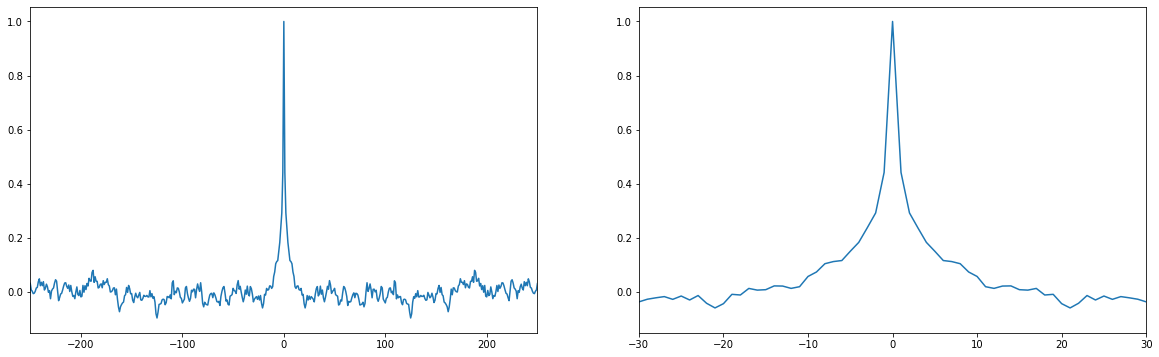

In [241]:
auto_fig,auto_axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
auto_axs[0].plot(autocorr_lags,cesm1_ts_annavg_autocorr)
auto_axs[0].set_xlim(-250,250)

auto_axs[1].plot(autocorr_lags,cesm1_ts_annavg_autocorr)
auto_axs[1].set_xlim(-30,30)

The autocorrelation initially falls off very steeply, but then there is a small pedestal around a 6-year lag that seems to extend the autocorrelation to being above the noise out to about 10 years.

(0.0, 40.0)

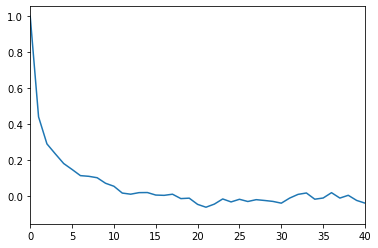

In [245]:
plt.plot(autocorr_lags[900:],cesm1_ts_annavg_autocorr[900:])
plt.xlim(0,40)

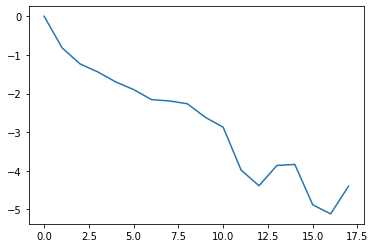

In [266]:
plt.plot(autocorr_lags[900:918],np.log(cesm1_ts_annavg_autocorr[900:918]))
# plt.xlim(0,40)

In [250]:
np.polyfit(autocorr_lags[900:916],np.log(cesm1_ts_annavg_autocorr[900:916]),deg=1)

array([-0.27965379, -0.41188513])

In [256]:
out = stats.linregress(autocorr_lags[900:916],np.log(cesm1_ts_annavg_autocorr[900:916]))

out

LinregressResult(slope=-0.27965379086500614, intercept=-0.4118851330826079, rvalue=-0.969499649634815, pvalue=6.074141456278447e-10, stderr=0.01889467405920058)

In [257]:
-1 / out[0]

3.5758499711620853

In [124]:
##### METHOD #1 - Numpy Method - Calculate FFT
freq = np.fft.rfftfreq(len(cesm1_annualavg_std),d=1.)
A = np.fft.rfft(cesm1_annualavg_std) # real fourier transform

# Drop the zero frequency component, it messes things up later
A = A[freq>0] # have to do this first before freq itself is changed
freq = freq[freq>0]

B = np.abs(A)**2
C = np.fft.irfft(B) # calculate the autocorrelation using the Weiner-Khinchin Theorem
C_norm = C / len(C)
C_norm_recenter = np.roll(C_norm,900)

cesm1_ts_annavg_autocorr = np.correlate(cesm1_annualavg_std,cesm1_annualavg_std,mode='same') / len(cesm1_annualavg_std)

Plot $E_{\nu}$

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


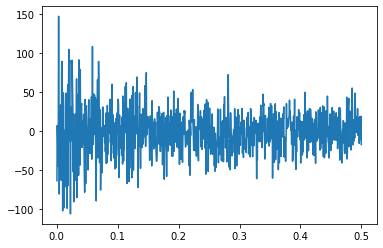

In [125]:
plt.plot(freq,A)

Plot $|E_{\nu}|^2$

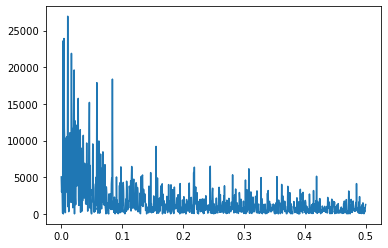

In [126]:
plt.plot(freq,B)

Scale the PSD by the weighting factor determined by the window:

$$ \langle m (\Delta t)^2 \rangle = \frac{2 A^2 \sin^2(\pi \Delta t f)}{{\Delta t}^2} $$

In [127]:
def psd_scaling(freq:np.array,delta_t:float):
    
    scaling = 2*np.sin(np.pi*delta_t*freq)**2 / delta_t**2
    
    return scaling

def psd_scaling_flat(freq:np.array,delta_t:float):
    
    scaling = np.repeat(2/delta_t**2,len(freq))
    
    return scaling

Multiply the PSD by our scaling factor, sort by the resulting amplitude and visualize to guess a function to fit to.

In [128]:
scaling_20yrs = psd_scaling(freq=freq,delta_t=20) # twenty years of observations
scaling_15yrs = psd_scaling(freq=freq,delta_t=15) # twenty years of observations
scaling_10yrs = psd_scaling(freq=freq,delta_t=10) # twenty years of observations

scalingf_20yrs = psd_scaling_flat(freq=freq,delta_t=20) # twenty years of observations
scalingf_15yrs = psd_scaling_flat(freq=freq,delta_t=15) # twenty years of observations
scalingf_10yrs = psd_scaling_flat(freq=freq,delta_t=10) # twenty years of observations

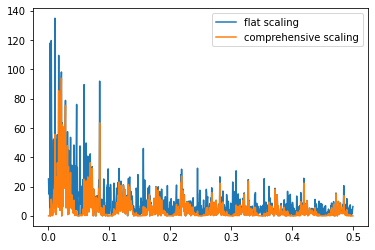

In [129]:
plt.plot(freq,scalingf_20yrs*B,label='flat scaling')
plt.plot(freq,scaling_20yrs*B,label='comprehensive scaling')

plt.legend()

Clearly frequencies that fit evenly into our observational period are damped. But it doesn't look like the flat scaling is doing what I thought it would. Probably because the low frequency noise is not evenly damped by the comprehensive filter.

Sort the trend steps and plot that distribution.

In [130]:
step_dist_20yrs = np.sort(scaling_20yrs*B)[::-1]

Try a flat scaling and see how it compares.

In [131]:
step_dist_20yrs_flat = np.sort(scalingf_20yrs*B)[::-1]

(array([785.,  67.,  29.,   6.,   1.,   5.,   3.,   0.,   2.,   2.]),
 array([1.29784580e-07, 9.38879536e+00, 1.87775906e+01, 2.81663858e+01,
        3.75551811e+01, 4.69439763e+01, 5.63327715e+01, 6.57215668e+01,
        7.51103620e+01, 8.44991572e+01, 9.38879525e+01]),
 <BarContainer object of 10 artists>)

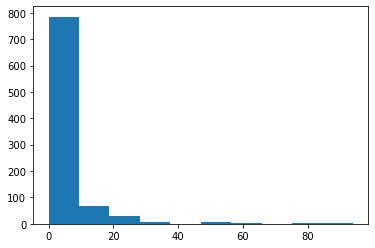

In [150]:
plt.hist(step_dist_20yrs)

(array([736., 108.,  21.,  16.,   9.,   2.,   3.,   1.,   3.,   1.]),
 array([2.81254568e-03, 1.34840238e+01, 2.69652350e+01, 4.04464462e+01,
        5.39276574e+01, 6.74088687e+01, 8.08900799e+01, 9.43712911e+01,
        1.07852502e+02, 1.21333714e+02, 1.34814925e+02]),
 <BarContainer object of 10 artists>)

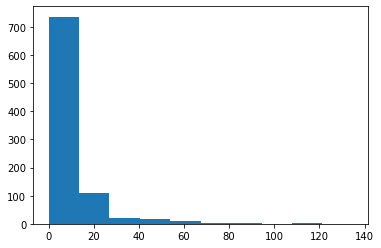

In [151]:
plt.hist(step_dist_20yrs_flat)

Text(0, 0.5, 'Mean square step length')

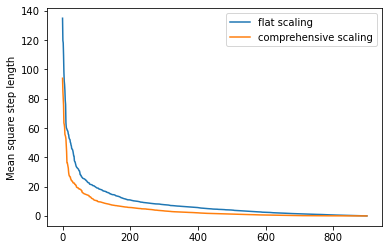

In [132]:
plt.plot(np.arange(len(step_dist_20yrs_flat)),step_dist_20yrs_flat,label='flat scaling')

plt.plot(np.arange(len(step_dist_20yrs)),step_dist_20yrs,label='comprehensive scaling')

plt.legend()
plt.ylabel('Mean square step length')

This looks like a nice exponential decay that I can fit to a simple distribution!

Text(0, 0.5, 'Mean step length')

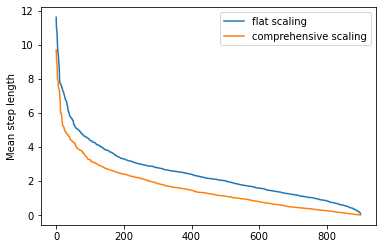

In [133]:
plt.plot(np.arange(len(step_dist_20yrs_flat)),np.sqrt(step_dist_20yrs_flat),label='flat scaling')

plt.plot(np.arange(len(step_dist_20yrs)),np.sqrt(step_dist_20yrs),label='comprehensive scaling')

plt.legend()
plt.ylabel('Mean step length')

Text(0, 0.5, 'Log of the Mean square step length')

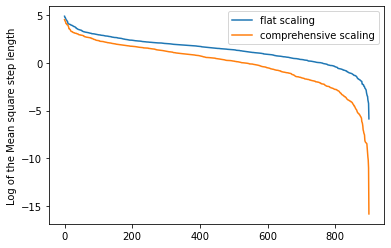

In [144]:
plt.plot(np.arange(len(step_dist_20yrs_flat)),np.log(step_dist_20yrs_flat),label='flat scaling')

plt.plot(np.arange(len(step_dist_20yrs)),np.log(step_dist_20yrs),label='comprehensive scaling')

plt.legend()
plt.ylabel('Log of the Mean square step length')

Text(0, 0.5, 'Log of the Mean step length')

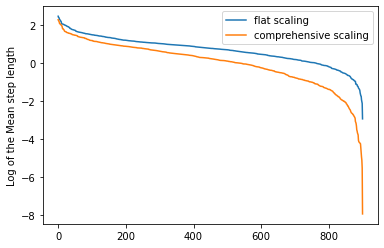

In [145]:
plt.plot(np.arange(len(step_dist_20yrs_flat)),np.log(np.sqrt(step_dist_20yrs_flat)),label='flat scaling')

plt.plot(np.arange(len(step_dist_20yrs)),np.log(np.sqrt(step_dist_20yrs)),label='comprehensive scaling')

plt.legend()
plt.ylabel('Log of the Mean step length')

I'm not sure if the mean step length is as nicely exponential, but it's worth a try.

In [146]:
log_data = np.log(np.sqrt(step_dist_20yrs))

In [147]:
x = np.arange(len(log_data))

p = np.polyfit(x, log_data, 1)

Convert back to the initial space and plot.

In [148]:
# Convert the polynomial back into an exponential
a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(b * x_fitted)

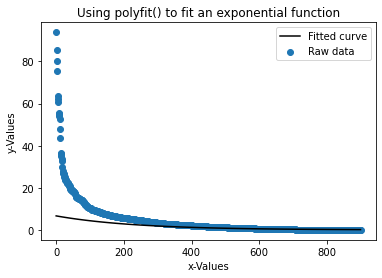

In [149]:
ax = plt.axes()
ax.scatter(x, step_dist_20yrs, label='Raw data')
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax.set_title('Using polyfit() to fit an exponential function')
ax.set_ylabel('y-Values')
# ax.set_ylim(0, 500)
ax.set_xlabel('x-Values')
ax.legend()

This isn't very good. I'll have to try and fit it to something else...

Construct step functions to remove the low-frequency climate noise.

In [27]:
highpass = np.concatenate((np.zeros(450),np.ones(451)))
lowpass = np.concatenate((np.ones(450),np.zeros(451)))

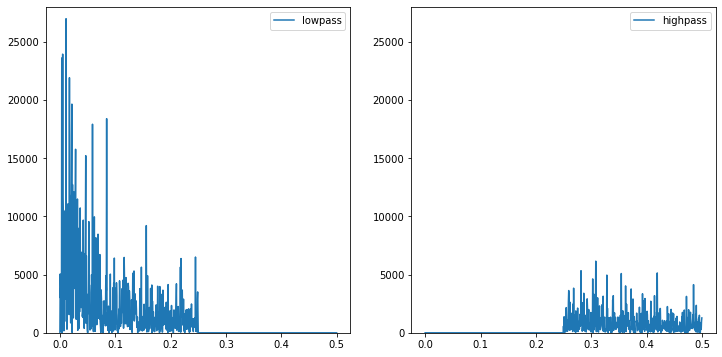

In [33]:
filtfig,filtaxs = plt.subplots(1,2,figsize=(12,6))
filtaxs[0].plot(freq,B*lowpass,label='lowpass')
filtaxs[1].plot(freq,B*highpass,label='highpass')
filtaxs[0].set_ylim(0,28e3)
filtaxs[1].set_ylim(0,28e3)

filtaxs[0].legend()
filtaxs[1].legend()

In [56]:
np.fft.irfft(B).sum()

-3.410605131648481e-13

In [50]:
np.fft.irfft(B*lowpass).sum()

-5.684341886080801e-13

In [51]:
np.fft.irfft(B*highpass).sum()

1.9895196601282805e-13

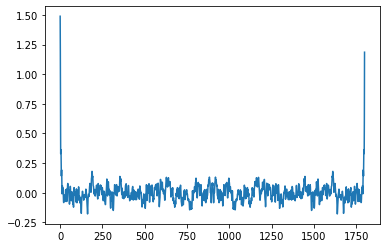

In [55]:
plt.plot(np.fft.irfft(B*lowpass) / len(B))

In [44]:
from scipy import signal
x = signal.unit_impulse(10,1)
print(x)
y = signal.unit_impulse(10, 7) # offset of 3
print(y)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Create fake power spectra for a toy example. One has power at a low frequency, and another has power at a high frequency.

In [48]:
np.fft.irfft(np.abs(x)**2).sum()

-2.7755575615628914e-17

In [49]:
np.fft.irfft(np.abs(y)**2).sum()

4.163336342344337e-17

They are both effectively zero...hmmm. They are also too close to zero for this to be random. The ifft must be taking in normalized data. This result is the same as having a normalized dataset...the autocorrelation function has to add up to zero.